### Setup Environment

In [1]:
import os

from diffusers.utils import numpy_to_pil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pycocotools.coco import COCO
import skimage.io as io
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.optimization import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from tqdm.notebook import tqdm
import time

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Load GPT-2 Tokenizer and Model

In [3]:
class LatentGPT(nn.Module):
    def __init__(self, gpt_dim=1280, latent_dim=2304) -> None:
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained('gpt2-large')
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.tokenizer.add_special_tokens(
            {
                "additional_special_tokens": [
                    "<latent>",
                ]
            }
        )

        self.gpt_model = AutoModelForCausalLM.from_pretrained('gpt2-large')
        self.gpt_model.resize_token_embeddings(len(self.tokenizer))

        self.gpt_dim = gpt_dim
        self.latent_dim = latent_dim

        self.hidden_proj = nn.Linear(self.gpt_dim, self.latent_dim)
    
    def hidden_2_latents(self, outputs, attention_mask):
        # Fetch last layer's hidden_state for chunk tokens
        last_hiddens = []
        for i in range(len(outputs['hidden_states'][-1])):
            last_tok_idx = torch.sum(attention_mask[i]) - 2
            last_hiddens.append(outputs['hidden_states'][-1][i][last_tok_idx].unsqueeze(0))
        
        return torch.cat(last_hiddens, dim=0)

    def forward(self, inputs_embeds, attention_mask):

        outputs = self.gpt_model(
            inputs_embeds=inputs_embeds,
            return_dict=True,
            output_hidden_states=True,
            attention_mask=attention_mask
        )

        last_hiddens = self.hidden_proj(
            self.hidden_2_latents(outputs, attention_mask)
        )

        return outputs, last_hiddens

In [4]:
%%capture
model = LatentGPT()
model.to(device)

### Setup Data for Training

In [5]:
coco_effnet_latents = np.load("stage_b_latents/coco_train2017_latents_v2_12.npy")
coco_latent_tensor = torch.Tensor(coco_effnet_latents).reshape(-1,  2304)
print(coco_latent_tensor.size())

torch.Size([118287, 2304])


In [6]:
class COCODataset(Dataset):
    def __init__(self, caption_file, image_dir):
        self.coco_captions = COCO(caption_file)

        self.files = os.listdir(image_dir)
        self.file_id_dict = {}
        self.coco_data = []

        # Create data tuples: (caption, image_id, CLIP embedding, index of embedding)
        for i, f in enumerate(self.files):
            file_id = int(f[:-4])
            self.file_id_dict[i] = file_id
            for ann_id in self.coco_captions.getAnnIds(imgIds=file_id):
                sample = self.coco_captions.loadAnns(ids=ann_id)[0]["caption"].strip() + "<latent>"

                self.coco_data.append(
                    (
                        sample, 
                        self.coco_captions.loadAnns(ids=ann_id)[0]["image_id"],
                        coco_latent_tensor[i].unsqueeze(0)
                    )
                )

    def __len__(self):
        return len(self.coco_data)

    def __getitem__(self, idx):
        return self.coco_data[idx]

In [7]:
coco_dataset = COCODataset(caption_file="../../Data/coco_captions/captions_train2017.json", image_dir="../../Data/coco_train2017")

loading annotations into memory...
Done (t=1.51s)
creating index...
index created!


In [8]:
def collate_fn(batch):
    captions, img_ids, latents = [], [], []
    for cap, im_id, lat in batch:
        captions.append(cap)
        img_ids.append(im_id)
        latents.append(lat)
    
    latents = torch.cat(latents, dim=0)
    
    return captions, img_ids, latents

sample

Image id: 2536
('A group of surfers are waiting on the water to catch the next wave.<latent>', 2536)


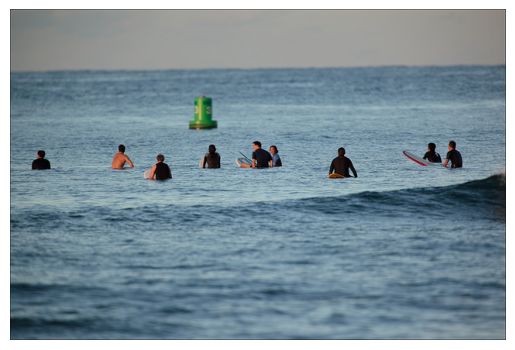

In [9]:
sample_id = 2547
print("Image id:", coco_dataset.coco_captions.loadImgs(coco_dataset.coco_data[sample_id][1])[0]['id'])
print(coco_dataset.coco_data[sample_id][:2])
I = io.imread(coco_dataset.coco_captions.loadImgs(coco_dataset.coco_data[sample_id][1])[0]['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

In [10]:
toks = model.tokenizer(["A group of surfers are waiting on the water to catch the next wave.<latent>"], padding=True, return_tensors='pt', return_attention_mask=True)
print(toks.input_ids)
print(toks['attention_mask'].sum())
print(toks.input_ids[0][toks['attention_mask'].sum()-1])
print(toks.input_ids[0][:toks['attention_mask'].sum()-1])

tensor([[   32,  1448,   286,  9053,   364,   389,  4953,   319,   262,  1660,
           284,  4929,   262,  1306,  6769,    13, 50257]])
tensor(17)
tensor(50257)
tensor([  32, 1448,  286, 9053,  364,  389, 4953,  319,  262, 1660,  284, 4929,
         262, 1306, 6769,   13])


### Tune GPT to predict CLIP embeddings from image captions as a continuous output

In [11]:
def train_lm(model, caps, latents):
    criterion_ce = torch.nn.CrossEntropyLoss()
    criterion_mse = torch.nn.MSELoss()

    targets = model.tokenizer(caps, padding=True, return_tensors='pt', return_attention_mask=True)
    input_ids = targets['input_ids'].to(device)
    attention_mask = targets['attention_mask'].to(device)
    token_embs = model.gpt_model.transformer.wte(input_ids)
    target_ids = input_ids.clone()
    del input_ids
    
    with torch.cuda.amp.autocast():
        outputs, proj_latents = model(
            inputs_embeds=token_embs,
            attention_mask=attention_mask
        )
    
        loss = criterion_ce(outputs['logits'][:, :-1].reshape(-1, outputs['logits'].size(-1)), target_ids[:, 1:].reshape(-1)) \
                + criterion_mse(proj_latents, latents.to(device))

    return loss


def caption_to_latent(model, optimizer, scheduler, dataloader, epochs=5):

    prev_time = time.time()
    
    model.train()
    for epoch in range(epochs):
       
        print(f"Training epoch: {epoch}")
        num_batches = len(dataloader)

        for batch_idx, (caps, _, latents) in  tqdm(enumerate(dataloader), total=num_batches):

            optimizer.zero_grad()

            loss = train_lm(model, caps, latents)
            loss.backward()

            optimizer.step()
            scheduler.step()
            
            if batch_idx % 1000 == 0 and batch_idx != 0:
                print(time.time() - prev_time)
                print(f"Loss at batch {batch_idx} / {num_batches}  = {loss}")

In [12]:
coco_dataloader = DataLoader(coco_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

epochs = 5
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=2000, num_training_steps=epochs * len(coco_dataloader))

caption_to_latent(model, optimizer, scheduler, coco_dataloader, epochs=epochs)

Training epoch: 0


  0%|          | 0/36985 [00:00<?, ?it/s]

245.69917154312134
Loss at batch 1000 / 36985  = 2.566059112548828
536.6746544837952
Loss at batch 2000 / 36985  = 2.789492130279541
828.8601055145264
Loss at batch 3000 / 36985  = 1.9309134483337402
1120.9470047950745
Loss at batch 4000 / 36985  = 2.4652764797210693
1413.7751524448395
Loss at batch 5000 / 36985  = 1.9819494485855103
1706.7788016796112
Loss at batch 6000 / 36985  = 2.8466906547546387
1999.9651472568512
Loss at batch 7000 / 36985  = 2.4373559951782227
2292.27464222908
Loss at batch 8000 / 36985  = 2.1839139461517334
2579.161638736725
Loss at batch 9000 / 36985  = 2.672513008117676
2841.886385679245
Loss at batch 10000 / 36985  = 2.60697340965271
3043.267019510269
Loss at batch 11000 / 36985  = 2.5599865913391113
3330.028157711029
Loss at batch 12000 / 36985  = 2.481318235397339
3640.924460172653
Loss at batch 13000 / 36985  = 2.4210362434387207
3955.3405044078827
Loss at batch 14000 / 36985  = 2.3241634368896484
4244.709372997284
Loss at batch 15000 / 36985  = 2.3351702

KeyboardInterrupt: 

### Save Model and Tokenizer

In [20]:
model.tokenizer.save_pretrained("pretrained_tokenizers/latent_gpt2_coco/")
torch.save(model.state_dict(), "pretrained_models/latent_gpt2_coco.pt")

### Load and Preview

In [5]:
%%capture
tokenizer = GPT2Tokenizer.from_pretrained("pretrained_tokenizers/latent_gpt2_coco/")

model = GPT2LMHeadModel.from_pretrained("pretrained_models/latent_gpt2_coco/").to(device)
model.eval()

In [13]:
# Effnet 16x16 to 64x64 previewer
class Previewer(nn.Module):
    def __init__(self, c_in=16, c_hidden=512, c_out=3):
        super().__init__()
        self.blocks = nn.Sequential(
            nn.Conv2d(c_in, c_hidden, kernel_size=1), # 36 channels to 512 channels
            nn.GELU(),
            nn.BatchNorm2d(c_hidden),

            nn.Conv2d(c_hidden, c_hidden, kernel_size=3, padding=1),
            nn.GELU(),
            nn.BatchNorm2d(c_hidden),

            nn.ConvTranspose2d(c_hidden, c_hidden//2, kernel_size=2, stride=2), # 16 -> 32
            nn.GELU(),
            nn.BatchNorm2d(c_hidden//2),

            nn.Conv2d(c_hidden//2, c_hidden//2, kernel_size=3, padding=1),
            nn.GELU(),
            nn.BatchNorm2d(c_hidden//2),

            nn.ConvTranspose2d(c_hidden//2, c_hidden//4, kernel_size=2, stride=2), # 32 -> 64
            nn.GELU(),
            nn.BatchNorm2d(c_hidden//4),

            nn.Conv2d(c_hidden//4, c_hidden//4, kernel_size=3, padding=1),
            nn.GELU(),
            nn.BatchNorm2d(c_hidden//4),

            nn.Conv2d(c_hidden//4, c_out, kernel_size=1),
        )

    def forward(self, x):
        return self.blocks(x)


previewer = Previewer()
previewer.load_state_dict(torch.load("models/text2img_wurstchen_b_v1_previewer_100k.pt")["state_dict"])
previewer.eval().requires_grad_(False).to(device)

Previewer(
  (blocks): Sequential(
    (0): Conv2d(16, 512, kernel_size=(1, 1), stride=(1, 1))
    (1): GELU(approximate='none')
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): GELU(approximate='none')
    (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (7): GELU(approximate='none')
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): GELU(approximate='none')
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (13): GELU(approximate='none')
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [38]:
def log_result(result):
    id, caption, url, similarity = result["id"], result["caption"], result["url"], result["similarity"]
    print(f"id: {id}")
    print(f"caption: {caption}")
    print(f"url: {url}")
    print(f"similarity: {similarity}")
    display(Image(url=url, unconfined=True))
    
    
def preview(model, text):
    model.eval()

    print("Input Text: ", text + "<latent>")
    tokens = model.tokenizer(text + "<latent>", return_tensors='pt')

    with torch.no_grad():
        outputs = model.gpt_model.generate(**tokens.to(device), return_dict_in_generate=True, output_hidden_states=True, max_new_tokens=50)

    print("Token ids: ", outputs['sequences'])
    print("Token count: ", len(outputs['sequences'][0]), end="\n\n")

    print("Output text: ", model.tokenizer.batch_decode(outputs['sequences'][0]))

    print("Length of hidden states (number of new tokens): ", len(outputs['hidden_states']))
    print("Number of hidden states (decoder layers + embedding layer): ", len(outputs['hidden_states'][-1]))
    print("(batch_size, gen_length, hidden_dim) =", outputs['hidden_states'][-1][-1].shape)

    pred_latent = model.hidden_proj(outputs['hidden_states'][-1][-1][:, -2]).reshape(16, 12, 12).unsqueeze(0)
    with torch.no_grad():
        output = previewer(pred_latent.mul(42).sub(1))
        output = numpy_to_pil(output.clamp(0, 1).permute(0, 2, 3, 1).cpu().numpy())
        
    return output

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Input Text:  A dog playing with a football.<latent>
Token ids:  tensor([[   32,  3290,  2712,   351,   257,  4346,    13, 50257, 50256]],
       device='cuda:0')
Token count:  9

Output text:  ['A', ' dog', ' playing', ' with', ' a', ' football', '.', '<latent>', '<|endoftext|>']
Length of hidden states (number of new tokens):  1
Number of hidden states (decoder layers + embedding layer):  37
(batch_size, gen_length, hidden_dim) = torch.Size([1, 8, 1280])


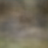

In [39]:
caption = "A dog playing with a football."
display(preview(model, caption)[0])

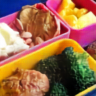

In [24]:
coco_effnet_latents = np.load("stage_b_latents/coco_train2017_latents_v2_24.npy")
coco_latent_tensor = torch.Tensor(coco_effnet_latents)

with torch.no_grad():
    output = previewer(coco_latent_tensor[0].unsqueeze(0).mul(42).sub(1).to(device))
    output = numpy_to_pil(output.clamp(0, 1).permute(0, 2, 3, 1).cpu().numpy())

display(output[0])